## 0. Import libraries

In [254]:
import torch
import pandas as pd
import numpy as np
import math, copy, time
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset 
from torch.optim import Adam
import tqdm
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

## 1. Load Data

In [255]:
df = pd.read_csv('./kospi.csv')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6762,2024-05-23,2719.030029,2734.270020,2704.000000,2721.810059,2721.810059,427400
6763,2024-05-24,2693.649902,2696.989990,2681.169922,2687.600098,2687.600098,501600
6764,2024-05-27,2697.159912,2725.080078,2693.659912,2722.989990,2722.989990,556700
6765,2024-05-28,2715.520020,2730.120117,2714.340088,2722.850098,2722.850098,441000
6766,2024-05-29,2719.560059,2721.629883,2678.090088,2679.189941,2679.189941,409427


In [256]:
df['kospi_shift'] = df['Adj Close'].shift(-1)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,kospi_shift
0,1996-12-11,705.989990,709.479980,704.429993,704.679993,704.679993,28000,689.380005
1,1996-12-12,705.109985,706.010010,688.739990,689.380005,689.380005,25900,689.070007
2,1996-12-13,690.440002,695.719971,677.640015,689.070007,689.070007,26500,673.919983
3,1996-12-16,686.969971,686.969971,667.710022,673.919983,673.919983,22800,663.349976
4,1996-12-17,675.349976,680.090027,660.390015,663.349976,663.349976,31600,661.390015


In [257]:
col_names = df.columns.values
print(col_names)

['Date' 'Open' 'High' 'Low' 'Close' 'Adj Close' 'Volume' 'kospi_shift']


In [258]:
# global variables and hyperparameter
IN_DIM = 128
DAY_INT = 1
BATCH_SIZE = 64
SCALER = 'MINMAX'   # 'NORMAL'
# SCALER = 'NORMAL'   # 'NORMAL'
TRAIN_TEST_SPLIT = 0.95
LR = 1e-4

## 2. Split data train and test

In [259]:
# train test split
df_train = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT), :]
df_test = df.iloc[int(len(df) * TRAIN_TEST_SPLIT): , :]
# print(df_train.tail())
# print(df_test.head())
scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
for i in col_names[1:]:
    scale_params[i] = [df_train[i].mean(), df_train[i].var(), df_train[i].max(), df_train[i].min()]
scale_params

,Open,High,Low,Close,Adj Close,Volume,kospi_shift
mean,1567.444804,1577.017282,1555.558617,1566.653486,1566.653486,4.352549e+05,1566.909651
var,516459.039009,518614.771196,512750.743107,515807.315879,515807.315879,7.423809e+10,515787.441260
max,3305.459961,3316.080078,3295.439941,3305.209961,3305.209961,3.455500e+06,3305.209961
min,283.410004,291.010010,277.369995,280.000000,280.000000,1.390000e+04,280.000000


In [260]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
if SCALER == 'MINMAX':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
test_data.tail()

,Open,High,Low,Close,Adj Close,Volume,kospi_shift
6762,0.805950,0.807671,0.804034,0.807154,0.807154,0.120148,0.795846
6763,0.797551,0.795347,0.796469,0.795846,0.795846,0.141707,0.807544
6764,0.798713,0.804633,0.800608,0.807544,0.807544,0.157717,0.807498
6765,0.804788,0.806299,0.807460,0.807498,0.807498,0.124099,0.793066
6766,0.806125,0.803492,0.795449,0.793066,0.793066,0.114925,NaN


In [261]:
train_x = np.zeros([(len(train_data) - 64 + 1), 64])
test_x = np.zeros([(len(test_data) - 64 + 1), 64])
train_x.shape, test_x.shape

((6365, 64), (276, 64))

In [262]:
class StockDataset(Dataset):
    def __init__(self, y, seq_len, input_window=128, output_window=1, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1
        start_pos = (L - input_window - output_window) % stride
        iter_times = (L - input_window - output_window) // stride + 1
        seq_iter = num_samples - seq_len + 1
        # print(y.shape, num_samples, iter_times, start_pos, L)

        #input과 output
        # X = np.zeros([input_window, num_samples])
        # Y = np.zeros([output_window, num_samples])
        X = np.zeros([num_samples, input_window])
        X_FFT = np.zeros([num_samples, input_window])
        X_random = np.zeros([num_samples, input_window])
        Y = np.zeros([num_samples, output_window])

        for i in np.arange(num_samples):
            start_x = start_pos + i * stride
            end_x = start_x + input_window
            X[i, :] = y[start_x:end_x]
            ft = np.fft.fftn(y[start_x:end_x], norm='forward')
            X_FFT[i, :] = abs(ft)

            # random values
            X_random[i, :] = np.random.randn(input_window) + X[i, :]

            # end_y = start_y + output_window
            # print(i, start_x, end_x)
            Y[i, :] = y[end_x: end_x + output_window]
        print(X.shape, Y.shape)
        print(X[-1, -1], '\n', Y[0])
        # X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        # Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))

        start_pos = num_samples % seq_len
        seq_iter = seq_iter - start_pos - 1
        X_ = np.zeros([seq_iter, seq_len, 3, input_window])
        Y_ = np.zeros([seq_iter, output_window])
        print('start pos:', start_pos, 'seq_iter:', seq_iter)
        for i in range(seq_iter):
            X_[i, :, 0, :] = X[(start_pos+i):(start_pos+seq_len+i), :]
            X_[i, :, 1, :] = X_FFT[(start_pos+i):(start_pos+seq_len+i), :]
            X_[i, :, 2, :] = X_random[(start_pos+i):(start_pos+seq_len+i), :]
            Y_[i, :] = Y[start_pos+seq_len+i-1, :]
            # print('i:', i, 'index start:', start_pos+i, 'index end:', start_pos+seq_len+i)
        # X_[0, :, :] = X[(start_pos+0*seq_len):(start_pos+(0+1)*seq_len), :]
        # Y_[0, :] = Y[start_pos+0*seq_len, :]
        print(X[(start_pos+i):(start_pos+seq_len+i), :].shape)
        print(X_.shape, Y_.shape)
        self.x = X_
        self.y = Y_
        
        self.len = len(X_)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

[1.31988255e-01 3.12271658e-03 1.29683371e-03 2.35780424e-03
 2.80902610e-03 9.73406883e-04 1.45464698e-03 7.41390180e-04
 5.13405540e-04 5.54392750e-04 6.60125892e-04 3.03655271e-04
 7.31274817e-04 4.41558934e-04 1.01014959e-04 1.81445632e-04
 5.30915635e-04 4.19992340e-04 5.34497679e-04 1.23551995e-04
 2.60700292e-04 7.37847060e-05 3.18493456e-04 3.70558504e-04
 1.07783208e-04 1.47474140e-04 1.16297853e-04 2.22296420e-04
 3.64346220e-04 1.53758572e-04 3.54410473e-04 3.88272864e-04
 1.69404937e-05 3.88272864e-04 3.54410473e-04 1.53758572e-04
 3.64346220e-04 2.22296420e-04 1.16297853e-04 1.47474140e-04
 1.07783208e-04 3.70558504e-04 3.18493456e-04 7.37847060e-05
 2.60700292e-04 1.23551995e-04 5.34497679e-04 4.19992340e-04
 5.30915635e-04 1.81445632e-04 1.01014959e-04 4.41558934e-04
 7.31274817e-04 3.03655271e-04 6.60125892e-04 5.54392750e-04
 5.13405540e-04 7.41390180e-04 1.45464698e-03 9.73406883e-04
 2.80902610e-03 2.35780424e-03 1.29683371e-03 3.12271658e-03] 0.17346486151359236


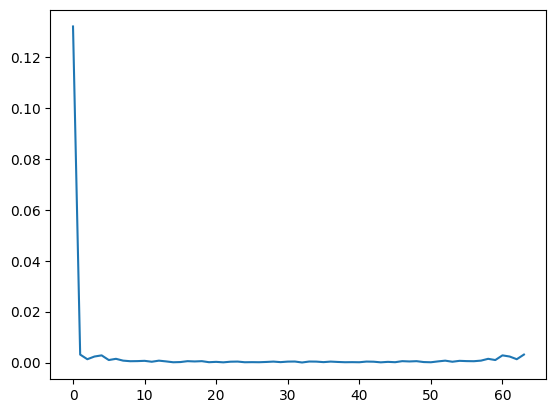

In [263]:
aa = train_data.loc[:63, 'Adj Close']
aa_ft = np.fft.fftn(aa, norm='forward')
print(abs(aa_ft), np.sum(abs(aa_ft)))
plt.plot(abs(aa_ft))
plt.show()

In [264]:
train_x = StockDataset(train_data['Adj Close'], 64, 64, 1, 1)
print('length of data', len(train_x))
print(next(iter(train_x))[1])

(6364, 64) (6364, 1)
0.6644067673505358 
 [0.12107919]
start pos: 28 seq_iter: 6272
(64, 64)
(6272, 64, 3, 64) (6272, 1)
length of data 6272
[0.14746745]


### 3. create dataloader

In [265]:
train_dataset = StockDataset(train_data['Adj Close'], 64, 64, 1, 1)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = StockDataset(test_data['Adj Close'], 64, 64, 1, 1)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
a1 = next(iter(train_dataset))
print(len(train_dataloader), len(train_dataloader.dataset), a1[0].shape, a1[1].shape)
# print(next(iter(test_dataset)))

(6364, 64) (6364, 1)
0.6644067673505358 
 [0.12107919]
start pos: 28 seq_iter: 6272
(64, 64)
(6272, 64, 3, 64) (6272, 1)
(275, 64) (275, 1)
0.8074977040268706 
 [0.75421539]
start pos: 19 seq_iter: 192
(64, 64)
(192, 64, 3, 64) (192, 1)
98 6272 (64, 3, 64) (1,)


In [266]:
for x1, y1 in train_dataloader:
    pass
print(x1[0], '\n', y1[63])

tensor([[[ 5.4338e-01,  5.4631e-01,  5.4234e-01,  ...,  5.4665e-01,
           5.4642e-01,  5.5257e-01],
         [ 5.2980e-01,  5.6214e-03,  4.7707e-03,  ...,  2.0765e-03,
           4.7707e-03,  5.6214e-03],
         [-1.0900e+00, -2.9264e+00,  9.6072e-02,  ...,  1.7944e+00,
           8.9449e-01, -8.5569e-01]],

        [[ 5.4631e-01,  5.4234e-01,  5.3878e-01,  ...,  5.4642e-01,
           5.5257e-01,  5.5378e-01],
         [ 5.2996e-01,  5.6511e-03,  4.9309e-03,  ...,  2.2388e-03,
           4.9309e-03,  5.6511e-03],
         [-7.6299e-01,  4.0415e-02,  1.3469e+00,  ...,  5.6142e-01,
          -2.4086e-02,  1.2370e-01]],

        [[ 5.4234e-01,  5.3878e-01,  5.2979e-01,  ...,  5.5257e-01,
           5.5378e-01,  5.6018e-01],
         [ 5.3018e-01,  5.6768e-03,  5.1476e-03,  ...,  2.4494e-03,
           5.1476e-03,  5.6768e-03],
         [ 6.1053e-01,  2.1305e+00, -1.2716e-01,  ...,  1.7112e+00,
           1.9046e-01,  8.6331e-01]],

        ...,

        [[ 5.4665e-01,  5.4642e-01,

In [267]:
for x1, y1 in test_dataloader:
    pass
print(x1[0].shape, '\n', y1[0].shape)

torch.Size([64, 3, 64]) 
 torch.Size([1])


## 4. Make a Transformer model

In this sections, we will implement the building blocks of the transformer: [Positional encoding](#1a), [Multi-head attention](#1b) and [Position wise feedforward network](#1c)

### a. Sinusoidal Positional Encoding
<a id='1a'></a>
In this section, we will implement sinusoidal positional encoding

$$\begin{align}
PE(pos, 2i) &= \sin \left( pos / 10000^{2i / d_{model}} \right)  \\
PE(pos, 2i+1) &= \cos \left( pos / 10000^{2i / d_{model}} \right)  
\end{align}$$

In [268]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model , max_len, device):
        """
        d_model: dimension of model
        max_len: maximum sequence length
        device: 'cuda' or 'cpu'
        """
        super().__init__()
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.required_grad = False

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1) # [a, b, ...] -> [[a], [b], [c], ...]

        _2i = torch.arange(0, d_model, step=2, device=device) # i is d_model and step=2 means 2*i
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
    
    def forward(self, x):
        # x: Tensor, shape ``[batch_size, seq_len, embedding_dim]
        # d_model = 512
        # print(x.size())
        batch_size, seq_len = x.size()[:2]
        pe = self.encoding[:seq_len, :]
        return pe

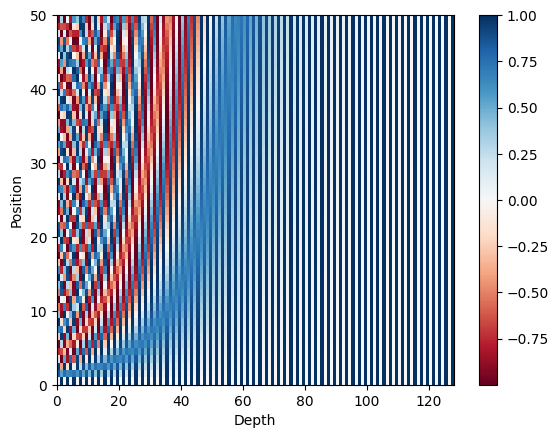

In [269]:
sample_pos_encoding = PositionalEncoding(128, 50, device='cpu')

plt.pcolormesh(sample_pos_encoding.encoding.numpy(), cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()


### b. Scaled dot product attention

__Scaled dot product:__
![picture](./assets/transformer_2.png)

In [270]:
class ScaleDotProductAttention(nn.Module):
    """
    Query: given setence
    Key: same with query(encoder)
    Value: same with key
    """

    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, q, k, v, mask=None, e=1e-12):
        # input: 4 dimension tensor
        # [batch_size, head, length, d_tensor]
        batch_size, head, length, d_tensor = k.size()

        # 1. q @ K.T
        k_t = k.transpose(2, 3)
        # print(q.size(), k_t.size())
        score = (q @ k_t) / math.sqrt(d_tensor)

        # 2. masking(decoder self attention only)
        if mask is not None:
            score = score.masked_fill(mask == 0, -10000)
        
        # 3. pass them softmax to [0, 1] range
        score = self.softmax(score)

        # 4. multiply with value
        v = score @ v

        return v, score

### c. MultiheadAttention
<a id='1b'></a>
Equation:

$$\begin{align} \text{MultiHead}(Q, K, V) &= \text{Concat}(head_1, ...., head_h) W^O \\
\text{where head}_i &= \text{Attention} \left( QW^Q_i, K W^K_i, VW^v_i \right)
\end{align}$$

In [271]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        # 1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. split tensor by heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # 3. scale dot product
        out, attention = self.attention(q, k, v, mask=mask)

        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        return out
    
    def split(self, tensor):
        '''
        split tensor by heads
        tensor: [batch_size, seq_len, d_model]
        return: [batch_size, head, seq_len, d_tensor] --- d_model = head * d_tensor
        '''
        batch_size, seq_len, d_model = tensor.size()
        d_tensor = d_model // self.n_head
        tensor = tensor.view(batch_size, seq_len, self.n_head, d_tensor).transpose(1, 2)
        # split by # of heads
        return tensor
    
    def concat(self, tensor):
        '''
        inverse of split(tensor)
        tensor: [batch_size, head, seq_len, d_tensor]
        return: [batch_size, seq_len, d_model]
        '''
        batch_size, head, seq_len, d_tensor = tensor.size()
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        return tensor
        

### d. Position-wise feed forward network
<a id='1c'></a>
In this section, we will implement position-wise feed forward network

$$\text{FFN}(x) = \max \left(0, x W_1 + b_1 \right) W_2 + b_2$$

In [272]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, dropout):
        super().__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x

### e. Layer Normalization

In [273]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True)
        # -1 to get mean and var for the last dimension(d_model)

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out

## 5. Embedding input data

make 1 input dimension data to d_model dimentions

In [274]:
class LinearEmbedding(nn.Module):
    def __init__(self, in_d, dropout, d_model):
        '''
        data: [batch_size, seq_len, in_d]
        In this model, only kospi input window
        '''
        super().__init__()
        self.d_model = d_model
        self.in_d = in_d
        print(type(in_d), type(d_model))
        self.linear1 = nn.Linear(in_d, d_model//2)
        self.linear2 = nn.Linear(d_model//2, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.normal1 = LayerNorm(d_model//2)
    
    def forward(self, x):
        '''
        input: [batch_size, seq_len, in_d]
        output: [batch_size, seq_len, d_model]
        '''
        if x.size()[-1] == self.d_model:
            return x
        else:
            x = self.linear1(x)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.normal1(x)
            x = self.linear2(x)
            x = self.relu(x)
            return x


In [275]:
class CNNEmbedding(nn.Module):
    def __init__(self, in_d, dropout, d_model):
        '''
        data: [batch_size, seq_len, in_d]
        In this model, only kospi input window
        '''
        super().__init__()
        self.d_model = d_model
        self.in_d = in_d
        print(type(in_d), type(d_model))
        self.conv1 = nn.Conv1d(64, 128, 3, padding=1) # 1*in_d -> 4*in_d
        self.max1d1 = nn.MaxPool1d(2, stride=2) # 4*in_d -> 4*in_d/2
        self.conv2 = nn.Conv1d(128, 256, 3, padding=1) # 4*in_d/2 -> 4*in_d/2
        self.max1d2 = nn.MaxPool1d(2, stride=2) # 4*in_d/2 -> 4*in_d/4
        self.linear1 = nn.Linear(in_d, d_model//2)
        self.linear2 = nn.Linear(d_model//2, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.normal1 = LayerNorm(d_model//2)
    
    def forward(self, x):
        '''
        input: [batch_size, seq_len, in_d]
        output: [batch_size, seq_len, d_model]
        '''
        # print(x.size())
        batch_size, seq_len, in_d = x.size()
        # x = x.unsqueeze(2)
        # print(x.size())
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max1d1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max1d2(x)
        x = x.view(batch_size, seq_len, -1)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.normal1(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x

In [276]:
class TrnasformerEmbedding(nn.Module):
    '''
    d_model: dimension of input data
    seq_len: max length of sequence
    '''
    def __init__(self, in_d, dropout, d_model, seq_len, device):
        # in_d, dropout, d_model, seq_len, device
        super().__init__()
        self.in_d = in_d
        self.d_model = d_model
        # self.lin_emb = LinearEmbedding(in_d, dropout, d_model)
        self.lin_emb = CNNEmbedding(in_d, dropout, d_model)
        # self.pos_emb = PositionalEncoding(d_model, seq_len, device)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        if self.in_d == self.d_model:
            lin_emb = x
        else:
            lin_emb = self.lin_emb(x)
        # pos_emb = self.pos_emb(x)
        # print(pos_emb.size(), lin_emb.size())
        return self.dropout(lin_emb)
        # return self.dropout(lin_emb + pos_emb)

## 6. Encoder Layer
Trnasformer Encoder Except Embedding

In [277]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, n_head, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.normal1 = LayerNorm(d_model=d_model)
        self.dropout1 = nn.Dropout(p=dropout)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, dropout=dropout)
        self.normal2 = LayerNorm(d_model=d_model)
        self.dropout2 = nn.Dropout(p=dropout)
    
    def forward(self, x, src_mask=None):
        # 1. multihead Attention
        residual = x
        x = self.attention(x, x, x)

        # 2. add and norm
        x = self.dropout1(x)
        x = self.normal1(x + residual)

        # 3. positionwise FFN
        residual = x
        x = self.ffn(x)

        # 4. add and norm
        x = self.dropout2(x)
        x = self.normal2(x + residual)

        return x

## 7. Encoder
Build Embedding and Encoder Block

In [278]:
class Encoder(nn.Module):
    def __init__(self, in_d, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device):
        # in_d, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device)
        super().__init__()
        self.emb = TrnasformerEmbedding(in_d, dropout, d_model, seq_len, device)
        self.layers = nn.ModuleList([EncoderLayer(d_model, ffn_hidden, n_head, dropout)
                                     for _ in range(n_layers)])
    
    def forward(self, x):
        x = self.emb(x)
        for layer in self.layers:
            x = layer(x)
        
        return x

## 8. Transformer Encoder
Only use encoder module and FFN 

In [279]:
class TransformerEncoder(nn.Module):
    def __init__(self, in_d, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, lstm_hidden_size, lstm_layers, device):
        super().__init__()
        self.encoder1 = Encoder(in_d, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device)
        self.encoder2 = Encoder(in_d, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device)
        self.encoder3 = Encoder(in_d, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device)

        # # self.flatten = nn.Flatten()
        self.lstm = nn.LSTM(d_model, lstm_hidden_size, lstm_layers, batch_first=True, dropout=dropout)
        # self.flatten_dim = seq_len * d_model
        self.linear1 = nn.Linear(lstm_hidden_size, lstm_hidden_size//2)
        self.linear2 = nn.Linear(lstm_hidden_size//2, 1)
        self.normal1 = nn.LayerNorm(lstm_hidden_size//2)

        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    
    def forward(self, x, i):
        # print('model dimention', x.size())
        # print('encode input0 dim', x[:, :, 0, :].squeeze().size())
        # print('encode input1 dim', x[:, :, 1, :].squeeze().size())

        # if i == 0:
        x_t = self.encoder1(x[:, :, 0, :].squeeze())
        x_fft = self.encoder2(x[:, :, 1, :].squeeze())
        x_random = self.encoder3(x[:, :, 2, :].squeeze())
        
        xs = x_t + x_fft + x_random
            # xs = x_t
        lstm_out, (hs, cs) = self.lstm(xs)
        # else:
        #     x = self.encoder(x)
        #     lstm_out, (hs, cs) = self.lstm(x)

        return lstm_out

In [280]:
class TFEncoderBlock(nn.Module):
    def __init__(self, tfl_layer, in_d, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, lstm_hidden_size, lstm_layers, device):
        super().__init__()
        self.layers = nn.ModuleList([TransformerEncoder(in_d, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, lstm_hidden_size, lstm_layers, device)
                                     for _ in range(tfl_layer)])
        self.linear1 = nn.Linear(lstm_hidden_size, lstm_hidden_size//2)
        self.linear2 = nn.Linear(lstm_hidden_size//2, 1)
        self.normal1 = nn.LayerNorm(lstm_hidden_size//2)

        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        # self.fft = nn.Parameter(torch.empty([BATCH_SIZE, seq_len, d_model], dtype=torch.float).to(device))
        self.tfl_layer_size = tfl_layer
        self.device = device

    def forward(self, x):
        
        for i, layer in enumerate(self.layers):
            x_t = layer(x, i)
            # print(x_t.dtype)
            if i != (self.tfl_layer_size - 1):
                x_fft = nn.Parameter(torch.FloatTensor.abs(torch.fft.fftn(x_t, norm='forward'))).to(self.device)
                x_t = x_t.unsqueeze(2)
                x_fft = x_fft.unsqueeze(2)
                x= torch.cat([x_t, x_fft], dim=2).contiguous()
                # print('x_fft size:', x_fft.size(), ', x size:', x.size())
                # print(x)
        out = x_t[:, -1, :]
        x = self.linear1(out)
        # print(x.size())
        x = self.relu(x)
        x = self.dropout(x)
        x = self.normal1(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x

## 9. model, loss_fn, optimizer


In [281]:
# next(iter(train_dataloader)).shape
# torch.cuda.empty.cache()
batch_size, seq_len, _, input_dim = next(iter(train_dataloader))[0].size()
print(batch_size, seq_len, input_dim)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
in_d = 64
model_d = 512
dropout = 0
ffn_hidden = model_d * 2
n_layers = 4
n_head = 4
lstm_hidden_size = model_d * 2
lstm_layers = 1
tfl_layer = 1
lr_sched = True
lr = 1e-6

64 64 64


In [282]:
model = TFEncoderBlock(tfl_layer, in_d, seq_len, model_d, ffn_hidden, n_head, dropout, n_layers, lstm_hidden_size, lstm_layers, device).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = lr)
if lr_sched == True:
    # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
    #                                     lr_lambda=lambda epoch: 0.95 ** epoch,
    #                                     last_epoch=-1,
    #                                     verbose=False)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.2)

<class 'int'> <class 'int'>
<class 'int'> <class 'int'>
<class 'int'> <class 'int'>


In [283]:
model

TFEncoderBlock(
  (layers): ModuleList(
    (0): TransformerEncoder(
      (encoder1): Encoder(
        (emb): TrnasformerEmbedding(
          (lin_emb): CNNEmbedding(
            (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
            (max1d1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            (conv2): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
            (max1d2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            (linear1): Linear(in_features=64, out_features=256, bias=True)
            (linear2): Linear(in_features=256, out_features=512, bias=True)
            (relu): ReLU()
            (dropout): Dropout(p=0, inplace=False)
            (normal1): LayerNorm()
          )
          (dropout): Dropout(p=0, inplace=False)
        )
        (layers): ModuleList(
          (0-3): 4 x EncoderLayer(
            (attention): MultiHeadAttention(
              (attention): S

## 10. Train and Test function

In [284]:
linear_model = CNNEmbedding(in_d, dropout, model_d).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
print(in_x.size())
out = linear_model(in_x[:, :, 0, :])
out.size()

<class 'int'> <class 'int'>
torch.Size([64, 64, 3, 64])


torch.Size([64, 64, 512])

In [285]:
emb_model = TrnasformerEmbedding(in_d, dropout, model_d, seq_len, device).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
print(in_x.shape, in_y.shape)
out = emb_model(in_x[:, :, 0, :].squeeze())
out.size()

<class 'int'> <class 'int'>
torch.Size([64, 64, 3, 64]) torch.Size([64, 1])


torch.Size([64, 64, 512])

In [286]:
encoder_model = Encoder(in_d, seq_len, model_d, ffn_hidden, n_head, dropout, n_layers, device).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = encoder_model(in_x[:, :, 0, :].squeeze())
print(out.size())
print(in_y.shape)
print(in_y.contiguous().view(-1).shape)

<class 'int'> <class 'int'>
torch.Size([64, 64, 512])
torch.Size([64, 1])
torch.Size([64])


In [287]:
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = model(in_x)
print(out.size())
print(in_y.shape)
print(in_y.contiguous().view(-1).shape)

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64])


In [288]:
epochs = 500
loss_np = np.zeros((epochs, 2))
df_loss = pd.DataFrame(loss_np, columns=['epoch', 'loss'])
for i in range(epochs):
    epoch_loss = 0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device).float()
        labels = labels.squeeze(1).to(device)

        optimizer.zero_grad()
        output = model(inputs)
        # print(output, labels)
        loss = loss_fn(output.squeeze().float(), labels.float())
        # print(loss)
        loss.backward()
        # torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)  # when using scheduler, it is not for grad exploding
        optimizer.step()

        epoch_loss += loss.item()
    
    print(f'epochs: {i}, loss: {epoch_loss:.6f}, lr: ', round(optimizer.param_groups[0]['lr'], 9))
    if lr_sched == True:
        scheduler.step()
    df_loss.loc[i, :] = [i, epoch_loss]

epochs: 0, loss: 2.987435, lr:  1e-06
epochs: 1, loss: 1.069898, lr:  1e-06
epochs: 2, loss: 0.731700, lr:  1e-06
epochs: 3, loss: 0.563813, lr:  1e-06
epochs: 4, loss: 0.472222, lr:  1e-06
epochs: 5, loss: 0.406431, lr:  1e-06
epochs: 6, loss: 0.356710, lr:  1e-06
epochs: 7, loss: 0.316078, lr:  1e-06
epochs: 8, loss: 0.288799, lr:  1e-06
epochs: 9, loss: 0.262380, lr:  1e-06
epochs: 10, loss: 0.241013, lr:  1e-06
epochs: 11, loss: 0.223912, lr:  1e-06
epochs: 12, loss: 0.212520, lr:  1e-06
epochs: 13, loss: 0.196788, lr:  1e-06
epochs: 14, loss: 0.186006, lr:  1e-06
epochs: 15, loss: 0.175133, lr:  1e-06
epochs: 16, loss: 0.165566, lr:  1e-06
epochs: 17, loss: 0.155616, lr:  1e-06
epochs: 18, loss: 0.147511, lr:  1e-06
epochs: 19, loss: 0.141974, lr:  1e-06
epochs: 20, loss: 0.134905, lr:  1e-06
epochs: 21, loss: 0.131133, lr:  1e-06
epochs: 22, loss: 0.129554, lr:  1e-06
epochs: 23, loss: 0.118935, lr:  1e-06
epochs: 24, loss: 0.116763, lr:  1e-06
epochs: 25, loss: 0.112293, lr:  1e

KeyboardInterrupt: 

In [ ]:
save_path = 'patch_tst_lstm_block_kospi_modeld_' + str(model_d) + '_seqlen' + str(seq_len) + '_layaers' + str(n_layers) + '_nhead' + str(n_head) + '.pt'
# save_path = 'kospi_only.pt'
torch.save(model.state_dict(), save_path)
print(save_path)
df_loss

patch_tst_lstm_block_kospi_modeld_256_seqlen64_layaers4_nhead4.pt


,epoch,loss
0,0.0,6.337302
1,1.0,3.218905
2,2.0,2.348686
3,3.0,1.839191
4,4.0,1.512505
...,...,...
995,995.0,0.012937
996,996.0,0.012937
997,997.0,0.012937
998,998.0,0.012937


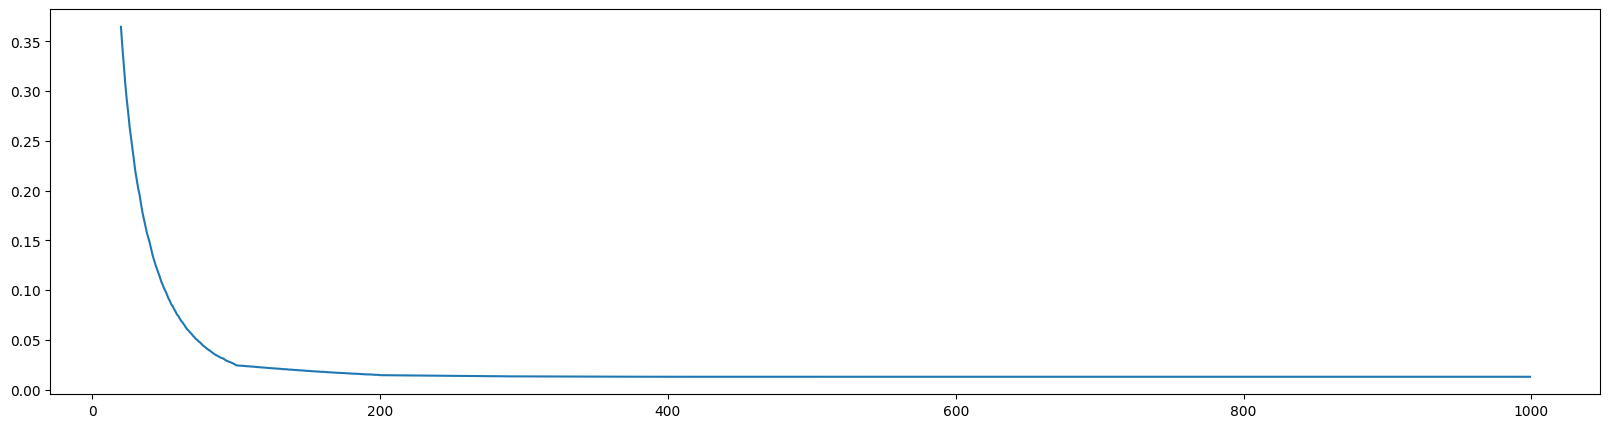

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df_loss.loc[20: , 'epoch'], df_loss.loc[20: , 'loss'])
plt.show()

In [291]:
test_result = pd.DataFrame(columns=['pred', 'pred_rescale', 'real'])
num = 0
min = scale_params.loc['min', 'Adj Close']
max = scale_params.loc['max', 'Adj Close']
with torch.no_grad():
    for _, data in enumerate(test_dataloader):
        inputs = data[0].to(device).float()
        # outputs = data[1].to(device).float()
        outputs = data[1]

        pred = model(inputs)
        for i in range(len(pred)):
            pred_ = pred.detach().cpu().numpy()[i][0]
            pred_scaled = pred_ * (max - min) + min
            out_scaled = outputs.numpy()[i] * (max - min) + min
            test_result.loc[num] = [pred_, pred_scaled, out_scaled[0]]
            num += 1

In [ ]:
test_result.to_csv('./test_result_patch_tft_lstm_block.csv')
test_result

,pred,pred_rescale,real
0,0.770331,2610.413992,2591.260010
1,0.755879,2566.694077,2570.870117
2,0.740969,2521.585724,2525.639893
3,0.773513,2620.039290,2519.850098
4,0.765868,2596.910806,2504.500000
...,...,...,...
187,0.782101,2646.020743,2723.459961
188,0.783602,2650.561836,2721.810059
189,0.807316,2722.300781,2687.600098
190,0.815720,2747.723974,2722.989990


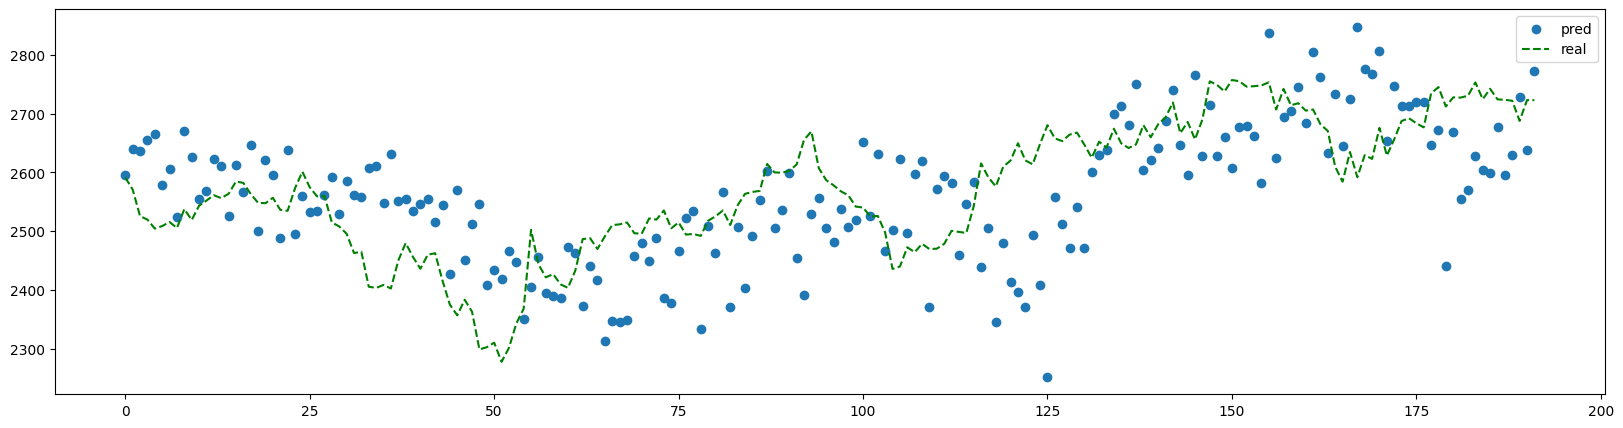

In [292]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['pred_rescale'], label='pred')
plt.scatter(range(len(test_result)), test_result['pred_rescale'], label='pred')
plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

In [290]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-20: , 1], label='pred')
plt.plot(range(20), test_result.iloc[-20: , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

NameError: name 'test_result' is not defined

<Figure size 2000x500 with 0 Axes>

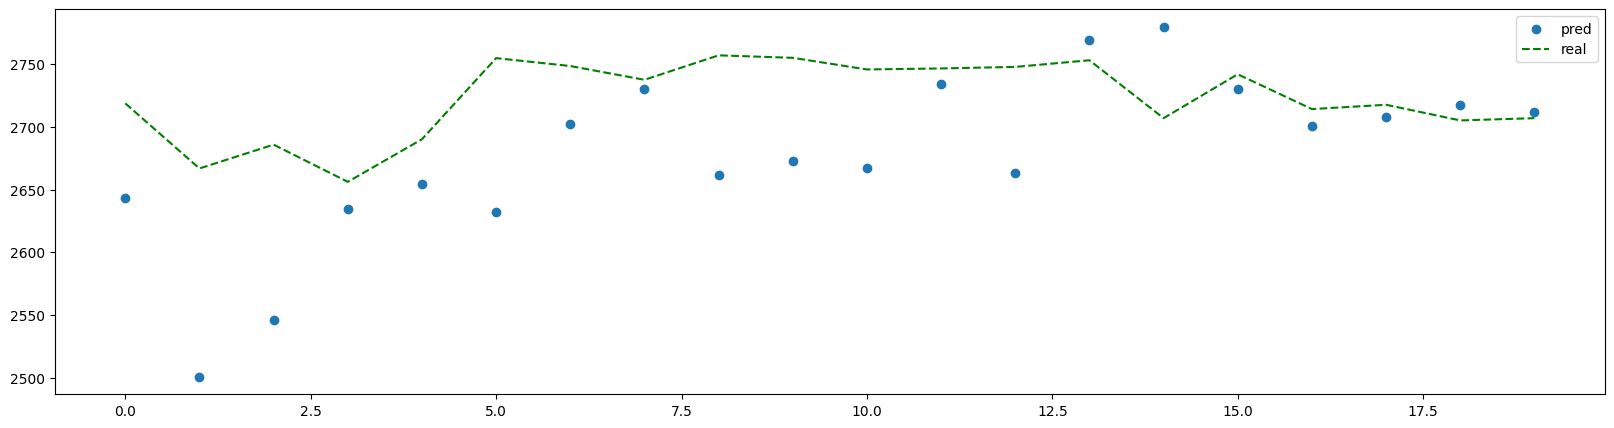

In [ ]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-50:-30 , 1], label='pred')
plt.plot(range(20), test_result.iloc[-50:-30 , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

In [ ]:
df_ma = test_result.copy()
df_ma['sma_pred_5d'] = df_ma['pred_rescale'].rolling(5).mean()
df_ma['sma_pred_10d'] = df_ma['pred_rescale'].rolling(10).mean()
df_ma['sma_pred_20d'] = df_ma['pred_rescale'].ewm(20).mean()
df_ma['sma_real_5d'] = df_ma['real'].rolling(5).mean()
df_ma['sma_real_10d'] = df_ma['real'].rolling(10).mean()
df_ma['sma_real_20d'] = df_ma['real'].rolling(20).mean()
df_ma['ewm_pred_5d'] = df_ma['pred_rescale'].ewm(5).mean()
df_ma['ewm_pred_10d'] = df_ma['pred_rescale'].ewm(10).mean()
df_ma['ewm_pred_20d'] = df_ma['pred_rescale'].ewm(20).mean()
df_ma['ewm_real_5d'] = df_ma['real'].ewm(5).mean()
df_ma['ewm_real_10d'] = df_ma['real'].ewm(10).mean()
df_ma['ewm_real_20d'] = df_ma['real'].ewm(20).mean()
df_ma = df_ma.dropna()
df_ma

,pred,pred_rescale,real,sma_pred_5d,sma_pred_10d,sma_pred_20d,sma_real_5d,sma_real_10d,sma_real_20d,ewm_pred_5d,ewm_pred_10d,ewm_pred_20d,ewm_real_5d,ewm_real_10d,ewm_real_20d
19,0.746200,2537.410306,2547.679932,2548.807503,2519.062302,2533.806041,2565.202002,2560.277979,2545.087988,2531.306561,2531.812785,2533.806041,2554.978804,2550.852041,2547.991777
20,0.738968,2515.533579,2556.879883,2531.938023,2523.082749,2532.448726,2559.667969,2561.624976,2543.368982,2528.619319,2530.101627,2532.448726,2555.302691,2551.485646,2548.652003
21,0.707997,2421.838207,2536.580078,2506.518076,2516.859303,2524.445738,2550.547998,2560.066992,2541.654480,2510.494149,2518.881102,2524.445738,2552.124689,2549.940818,2547.778565
22,0.709384,2426.034714,2534.699951,2490.193440,2509.511601,2517.497280,2544.819971,2557.414990,2542.107483,2496.201835,2509.379387,2517.497280,2549.176057,2548.381098,2546.855130
23,0.741943,2524.534261,2572.889893,2485.070214,2509.815651,2517.982972,2549.745947,2559.076978,2544.759473,2500.984062,2510.912782,2517.982972,2553.178713,2550.860938,2548.652046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.782101,2646.020743,2723.459961,2669.188212,2694.963005,2699.084113,2733.479980,2730.976978,2699.853491,2692.541812,2705.692201,2699.084113,2722.007220,2709.457601,2693.483271
188,0.783602,2650.561836,2721.810059,2668.934002,2695.403590,2696.773299,2727.241992,2728.652979,2704.471997,2685.545149,2700.680349,2696.773299,2721.974360,2710.580551,2694.832299
189,0.807316,2722.300781,2687.600098,2670.463303,2698.074764,2697.989008,2719.837988,2726.198999,2707.701001,2691.671088,2702.645843,2697.989008,2716.245316,2708.491419,2694.487876
190,0.815720,2747.723974,2722.989990,2682.499470,2694.087171,2700.357553,2716.008008,2725.735010,2710.063000,2701.013236,2706.743855,2700.357553,2717.369429,2709.809471,2695.845241


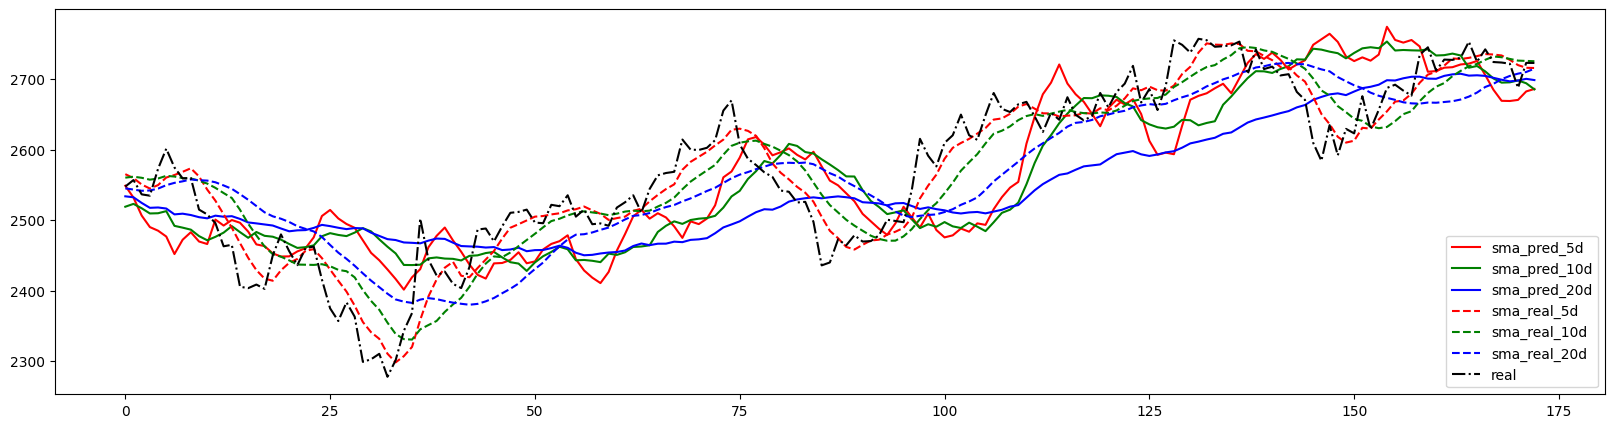

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['sma_pred_5d'], 'r-', label='sma_pred_5d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_10d'], 'g-', label='sma_pred_10d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_20d'], 'b-', label='sma_pred_20d')
plt.plot(range(len(df_ma)), df_ma['sma_real_5d'], 'r--', label='sma_real_5d')
plt.plot(range(len(df_ma)), df_ma['sma_real_10d'], 'g--', label='sma_real_10d')
plt.plot(range(len(df_ma)), df_ma['sma_real_20d'], 'b--', label='sma_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

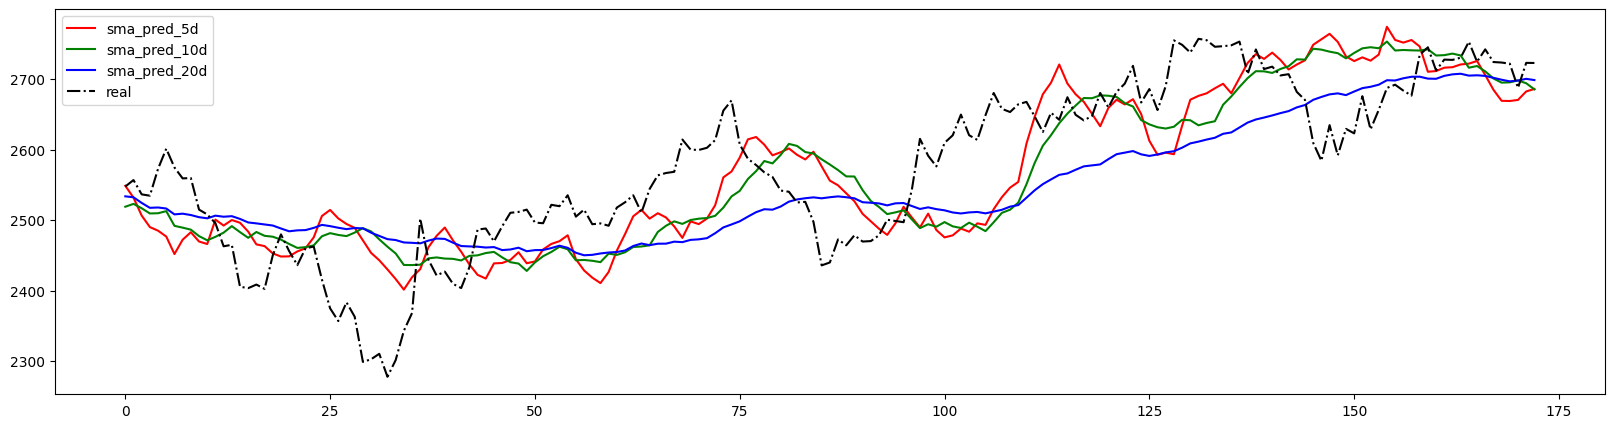

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['sma_pred_5d'], 'r-', label='sma_pred_5d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_10d'], 'g-', label='sma_pred_10d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_20d'], 'b-', label='sma_pred_20d')
# plt.plot(range(len(df_ma)), df_ma['sma_real_5d'], 'r--', label='sma_real_5d')
# plt.plot(range(len(df_ma)), df_ma['sma_real_10d'], 'g--', label='sma_real_10d')
# plt.plot(range(len(df_ma)), df_ma['sma_real_20d'], 'b--', label='sma_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

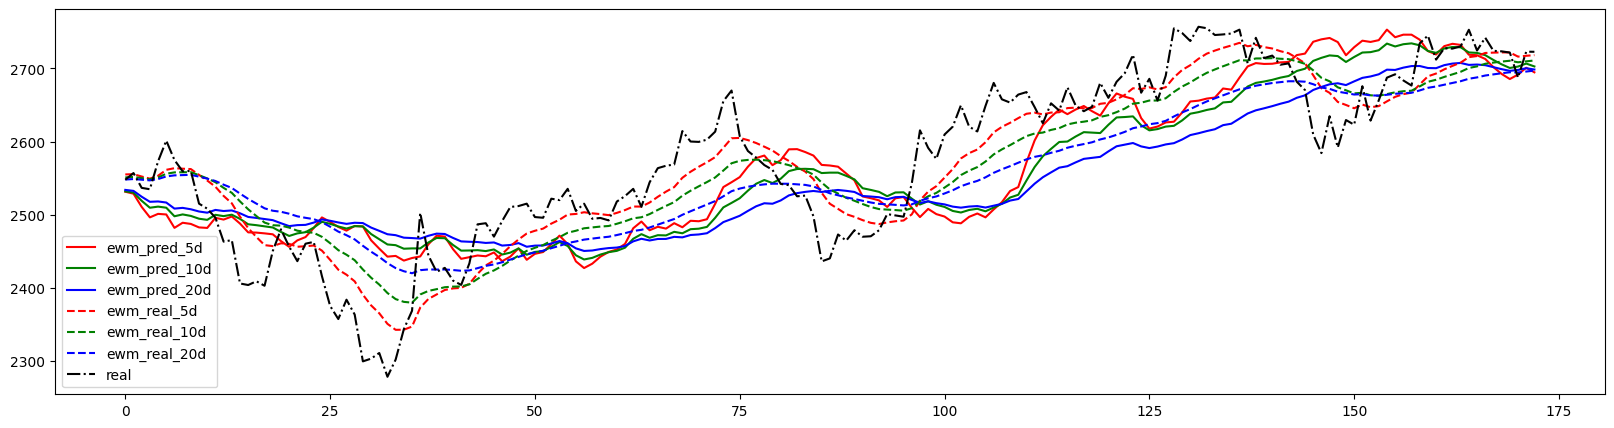

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['ewm_pred_5d'], 'r-', label='ewm_pred_5d')
plt.plot(range(len(df_ma)), df_ma['ewm_pred_10d'], 'g-', label='ewm_pred_10d')
plt.plot(range(len(df_ma)), df_ma['ewm_pred_20d'], 'b-', label='ewm_pred_20d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_5d'], 'r--', label='ewm_real_5d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_10d'], 'g--', label='ewm_real_10d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_20d'], 'b--', label='ewm_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

## 11. evaluation metrics
MAPE, MSE

In [ ]:
mse = mean_squared_error(test_result['real'], test_result['pred_rescale'])
mape = mean_absolute_percentage_error(test_result['real'], test_result['pred_rescale'])
print(f'MSE: {mse:.4f}, MAPE: {mape:.4f}')

MSE: 6687.1880, MAPE: 0.0262
